In [55]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import csv
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.init as init
import random
import torch.optim as optim

## Initial setup

In [7]:
sns.set()

In [8]:
os.chdir('/zfs/projects/darc/wolee_edehaan_suzienoh-exploratory-ml')

In [9]:
# Declare global variables
global con_list
global dum_list
global deps
global header

In [10]:
# List of continuous variables
con_list = ['absacc', 'acc', 'aeavol', 'age', 'agr', 'baspread', 'beta', 
            'betasq', 'bm', 'bm_ia', 'cash', 'cashdebt', 'cashpr','cfp', 
            'cfp_ia', 'chatoia', 'chcsho', 'chempia', 'chfeps', 'chinv', 
            'chmom', 'chnanalyst', 'chpmia', 'chtx', 'cinvest', 'currat', 
            'depr', 'disp', 'dolvol', 'dy', 'ear', 'egr', 'ep', 'fgr5yr', 
            'gma', 'grcapx', 'grltnoa', 'herf', 'hire', 'idiovol', 'ill', 
            'indmom', 'invest', 'lev', 'lgr', 'maxret', 'mom12m', 'mom1m', 
            'mom36m', 'mom6m', 'ms', 'mve', 'mve_ia', 'nanalyst', 'nincr', 
            'operprof', 'orgcap', 'pchcapx_ia', 'pchcurrat', 'pchdepr', 
            'pchgm_pchsale', 'pchquick', 'pchsale_pchinvt', 'pchsale_pchrect', 
            'pchsale_pchxsga', 'pchsaleinv', 'pctacc', 'pricedelay', 'ps', 
            'quick', 'rd_mve', 'rd_sale', 'realestate', 'retvol', 'roaq', 
            'roavol', 'roeq', 'roic', 'rsup', 'salecash', 'saleinv', 
            'salerec', 'secured', 'sfe', 'sgr', 'sp', 'std_dolvol', 
            'std_turn', 'stdacc', 'stdcf', 'sue', 'tang', 'tb', 'turn', 
            'zerotrade']


# List of dummy variables
dum_list = ['convind', 'divi', 'divo', 'ipo', 'rd', 'securedind', 'sin'] # Categorical variable binary 

# List of dependent variable
deps = con_list + dum_list +['date']

# Headers
header = ['permno','pyear']

## Load and preprocess data

In [11]:
def load_and_preprocess_data(file_path, period):
    
    """
    Loads and preprocesses the input data.

    Args:
    file_path (str): The path to the CSV file to be loaded.

    Returns:
    DataFrame: Preprocessed pandas DataFrame.
    """
    
    # Load data
    df = pd.read_csv(file_path)
    df.columns = [e.lower() for e in df.columns]
    
    df['date'] = df['date'].copy()
    df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
    # df['date'] = df['date'].dt.strftime('%m-%d-%Y')

    # Extract year
    df['pyear'] = df['date'].dt.year
    # Remove months if quarterly, otherwise, monthly, keep all months
    if period == 'quarter':
        df = df[df['date'].dt.month.isin([1,4,7,10])]

    # df.sort_values(['permno','date'], inplace=True)
    df.sort_values(['date', 'permno'], inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m')
    del df['fpedats']
    
    print(df[['date', 'permno']].head())
    print('-' * 50)
        
    return df

In [12]:
class CustomWinsorizer(BaseEstimator, TransformerMixin):
    
    """
    A custom transformer for Winsorizing numeric data.

    Attributes:
    lower_percentile (int): The lower percentile for clipping data.
    upper_percentile (int): The upper percentile for clipping data.
    """
    
    def __init__(self, lower_percentile, upper_percentile):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile

    def fit(self, X, y=None):
        self.lower_bound_ = np.percentile(X, self.lower_percentile)
        self.upper_bound_ = np.percentile(X, self.upper_percentile)
        return self

    def transform(self, X):
        X_clipped = np.clip(X, self.lower_bound_, self.upper_bound_)
        
        return X_clipped

In [13]:
class timePeriodMeanTransformer(BaseEstimator, TransformerMixin):
    
    """
    A custom transformer for imputing missing data based on time period means.

    Attributes:
    date_column (str): The column name representing dates.
    numeric_columns (list): List of numeric column names for which means are calculated.
    period (str): The time period for grouping data, either 'quarter' or 'month'.
    """
    
    def __init__(self, date_column, numeric_columns, period='quarter'):
        self.date_column = date_column
        self.numeric_columns = numeric_columns
        self.period = period

    def fit(self, X, y=None):
        X[self.date_column] = pd.to_datetime(X[self.date_column])
        if self.period == 'quarter':
            X['Period'] = X[self.date_column].dt.quarter
        elif self.period == 'month':
            X['Period'] = X[self.date_column].dt.month
        else:
            raise ValueError("period must be 'quarter' or 'month'")
       
       # Calculate and store the means of each numeric column for each time period
        self.period_means_ = X.groupby('Period')[self.numeric_columns].mean()
        return self

    def transform(self, X):
        X[self.date_column] = pd.to_datetime(X[self.date_column])
        if self.period == 'quarter':
            X['Period'] = X[self.date_column].dt.quarter
        elif self.period == 'month':
            X['Period'] = X[self.date_column].dt.month
        
        for col in self.numeric_columns:
            X[col] = X.apply(lambda row: row[col] if not pd.isna(row[col]) 
                             else self.period_means_.loc[row['Period'], col], axis=1)
        # return X.drop(['Period'], axis=1)
        return X

In [14]:
def build_pipeline(con_list, dum_list, lower_percentile, upper_percentile, period):
    
    """
    Builds a preprocessing pipeline for both numeric and categorical data.

    Args:
    con_list (list): List of continuous variable names.
    dum_list (list): List of dummy (categorical) variable names.
    lower_percentile (float): Lower percentile for winsorization.
    upper_percentile (float): Upper percentile for winsorization.
    period (string): Period for getting mean values (month vs quarter)

    Returns:
    Pipeline: A composed preprocessing pipeline.
    """
    
    numeric_pipeline = Pipeline([
        # ('fill_na', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
        ('winsorizer', CustomWinsorizer(lower_percentile=lower_percentile, upper_percentile=upper_percentile)),
        ('scaler', StandardScaler()),
        ('impute_con', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0))
    ])

    categorical_pipeline = Pipeline([
        ('impute_cat', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ])

    preprocessing = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, con_list),
            ('cat', categorical_pipeline, dum_list)
        ], remainder='passthrough')

    pipeline = Pipeline([
        ('Time_period_mean_imputation', timePeriodMeanTransformer('date', con_list, period)),
        ('Preprocessing', preprocessing),
    ])
    
    return pipeline

In [15]:
infile_path = 'Info Processing and Mutual Funds/masterv14.csv'
period = 'month'

In [16]:
if period == 'quarter':
    target = 'retq'
elif period == 'month':
    target = 'ret'
else:
    raise ValueError("period must be 'quarter' or 'month'")

In [17]:
# Load and preprocess data
print('\nLoading and preprocessing data...\n')
df = load_and_preprocess_data(infile_path, period)


Loading and preprocessing data...

      date  permno
0  1980-01   10006
1  1980-01   10057
2  1980-01   10103
3  1980-01   10137
4  1980-01   10145
--------------------------------------------------


In [18]:
# Drop null values in the target column and get years 2020 or prior
df1 = df.dropna(subset=[target])
df1 = df1[df1['pyear'] <= 2020]
df1.reset_index(drop=True, inplace=True)

In [19]:
df1

,permno,gvkey,adatadate,fyear,sic2,spi,mve_f,bm,ep,cashpr,...,std_dolvol,std_turn,ill,zerotrade,beta,betasq,rsq1,pricedelay,idiovol,pyear
0,10006,1010,12/31/1978,1978,37,0.0000,269.308500,1.180962,0.153022,-32.218678,...,0.881844,0.635898,2.565667e-08,1.115306e-07,1.060420,1.124491,0.343408,0.029859,0.025576,1980
1,10057,1098,09/30/1978,1978,36,0.0000,97.372000,0.956692,0.135131,-4.408581,...,1.368363,2.546787,2.719812e-07,6.199128e-08,1.526013,2.328716,0.307905,0.092667,0.037473,1980
2,10103,1012,10/31/1978,1978,33,NaN,1.697500,3.362003,0.338144,-17.143817,...,NaN,NaN,NaN,NaN,1.759493,3.095816,0.096753,0.221851,0.087020,1980
3,10137,1279,12/31/1978,1978,49,NaN,537.524500,1.330341,0.153238,-87.819837,...,0.553246,0.740017,1.765620e-08,9.726790e-08,0.492885,0.242936,0.189693,0.125777,0.017540,1980
4,10145,1300,12/31/1978,1978,99,-0.0031,805.633282,1.579284,0.149248,-22.050470,...,0.427617,0.657563,2.898901e-09,6.190654e-08,1.139163,1.297691,0.279437,0.024228,0.031201,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165510,93422,154357,12/31/2019,2019,13,-0.0090,1069.650000,2.487356,-0.090964,-14.117559,...,0.797001,12.233361,7.505129e-09,5.571619e-09,2.691027,7.241625,0.265207,0.257939,0.132692,2020
2165511,93423,10567,12/31/2019,2019,79,0.0004,3817.839740,-0.187572,0.046902,19.464647,...,0.519033,17.649093,4.462048e-10,3.803709e-09,1.921529,3.692274,0.485215,0.068369,0.061119,2020
2165512,93426,185138,12/31/2019,2019,36,-0.0108,459.782000,0.524944,0.048258,1.095352,...,0.473367,2.144264,2.296462e-08,3.236729e-08,1.302016,1.695247,0.472220,0.037482,0.043174,2020
2165513,93434,184259,06/30/2019,2019,1,-0.1349,87.853920,1.138777,-0.105914,-13.505851,...,0.935967,0.897075,3.435272e-07,1.037670e-07,0.389842,0.151977,0.021429,-0.694649,0.073887,2020


In [20]:
sample = df1.loc[df1['permno']==10103]

In [21]:
sample[['permno', 'date']]

,permno,date
2,10103,1980-01
3462,10103,1980-02
6932,10103,1980-03
10441,10103,1980-04
13941,10103,1980-05
...,...,...
479711,10103,1989-07
484311,10103,1989-08
488942,10103,1989-09
493659,10103,1989-10


## Transform data

In [22]:
print('Training in progress...\n')
# Build a training pipeline
pipeline = build_pipeline(con_list, dum_list, 5, 95, period)

Training in progress...



In [23]:
pipeline

Pipeline(steps=[('Time_period_mean_imputation',
                 timePeriodMeanTransformer(date_column='date',
                                           numeric_columns=['absacc', 'acc',
                                                            'aeavol', 'age',
                                                            'agr', 'baspread',
                                                            'beta', 'betasq',
                                                            'bm', 'bm_ia',
                                                            'cash', 'cashdebt',
                                                            'cashpr', 'cfp',
                                                            'cfp_ia', 'chatoia',
                                                            'chcsho', 'chempia',
                                                            'chfeps', 'chinv',
                                                            'chmom',
                                                            'chnanalyst',
                                                            'chpmia', 'chtx',
                                                            'cinvest', 'currat',
                                                            'depr', 'disp',
                                                            'dolvol...
                                                   'beta', 'betasq', 'bm',
                                                   'bm_ia', 'cash', 'cashdebt',
                                                   'cashpr', 'cfp', 'cfp_ia',
                                                   'chatoia', 'chcsho',
                                                   'chempia', 'chfeps', 'chinv',
                                                   'chmom', 'chnanalyst',
                                                   'chpmia', 'chtx', 'cinvest',
                                                   'currat', 'depr', 'disp',
                                                   'dolvol', 'dy', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['convind', 'divi', 'divo',
                                                   'ipo', 'rd', 'securedind',
                                                   'sin'])]))])

In [24]:
# Set year range of the sample
years = list(sample['pyear'].drop_duplicates().sort_values())

In [25]:
years

[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989]

In [26]:
year = 1986

In [27]:
train_data = sample.loc[(sample['pyear']<=year)]
test_data = sample.loc[(sample['pyear']==year+1)]

In [28]:
# Training and testing data
training_years = sorted(train_data.pyear.unique())
print(f'Training Years: {training_years}\n')
print(f'Testing Year: {test_data.pyear.unique()}')

Training Years: [1980, 1981, 1982, 1983, 1984, 1985, 1986]

Testing Year: [1987]


In [29]:
train_data

,permno,gvkey,adatadate,fyear,sic2,spi,mve_f,bm,ep,cashpr,...,std_dolvol,std_turn,ill,zerotrade,beta,betasq,rsq1,pricedelay,idiovol,pyear
2,10103,1012,10/31/1978,1978,33,NaN,1.697500,3.362003,0.338144,-17.143817,...,NaN,NaN,NaN,NaN,1.759493,3.095816,0.096753,0.221851,0.087020,1980
3462,10103,1012,10/31/1978,1978,33,NaN,1.697500,3.362003,0.338144,-17.143817,...,NaN,NaN,NaN,NaN,1.736435,3.015207,0.088872,0.124053,0.090373,1980
6932,10103,1012,10/31/1978,1978,33,NaN,1.697500,3.362003,0.338144,-17.143817,...,NaN,NaN,NaN,NaN,1.546370,2.391259,0.065518,-0.026851,0.096490,1980
10441,10103,1012,10/31/1978,1978,33,NaN,1.697500,3.362003,0.338144,-17.143817,...,NaN,NaN,NaN,NaN,1.544397,2.385163,0.065431,0.024635,0.096057,1980
13941,10103,1012,10/31/1979,1979,33,-0.0537,1.196125,3.833059,-0.434737,-40.641964,...,NaN,NaN,NaN,NaN,1.353537,1.832062,0.069685,-0.237500,0.097406,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319599,10103,1012,10/31/1985,1985,33,-0.0306,3.654000,2.275041,0.173508,-20.234694,...,0.970630,0.430200,4.102243e-06,12.409091,0.255926,0.065498,-0.004113,0.565691,0.070953,1986
324006,10103,1012,10/31/1985,1985,33,-0.0306,3.654000,2.275041,0.173508,-20.234694,...,0.693619,0.102686,4.734849e-06,13.000002,0.295377,0.087248,-0.003160,0.761472,0.071049,1986
328503,10103,1012,10/31/1985,1985,33,-0.0306,3.654000,2.275041,0.173508,-20.234694,...,1.260025,0.589355,6.410256e-07,16.000000,0.311741,0.097183,-0.002642,0.756879,0.070830,1986
332973,10103,1012,10/31/1985,1985,33,-0.0306,3.654000,2.275041,0.173508,-20.234694,...,0.575778,0.242380,5.204745e-06,15.521740,0.402515,0.162018,0.000413,1.071883,0.070324,1986


In [30]:
test_data

,permno,gvkey,adatadate,fyear,sic2,spi,mve_f,bm,ep,cashpr,...,std_dolvol,std_turn,ill,zerotrade,beta,betasq,rsq1,pricedelay,idiovol,pyear
341802,10103,1012,10/31/1985,1985,33,-0.0306,3.65400,2.275041,0.173508,-20.234694,...,1.231006,1.800102,1.090449e-06,10.500000,0.361593,0.130749,-0.000917,0.742484,0.069696,1987
346169,10103,1012,10/31/1985,1985,33,-0.0306,3.65400,2.275041,0.173508,-20.234694,...,1.335870,1.067087,2.457757e-06,14.000000,0.416393,0.173383,0.000707,0.478180,0.069820,1987
350559,10103,1012,10/31/1985,1985,33,-0.0306,3.65400,2.275041,0.173508,-20.234694,...,1.151043,0.556207,1.305952e-06,7.736842,0.441242,0.194694,0.002159,0.686020,0.069377,1987
354962,10103,1012,10/31/1985,1985,33,-0.0306,3.65400,2.275041,0.173508,-20.234694,...,1.176656,2.029221,3.228941e-06,10.500000,0.455675,0.207640,0.002806,0.675348,0.069471,1987
359356,10103,1012,10/31/1986,1986,33,0.0000,4.71975,1.851793,0.090471,-13.191343,...,1.617956,0.744302,4.896825e-06,10.000000,0.552083,0.304795,0.005441,0.690085,0.073579,1987
363768,10103,1012,10/31/1986,1986,33,0.0000,4.71975,1.851793,0.090471,-13.191343,...,0.961905,0.416399,5.807201e-06,16.800001,0.593509,0.352253,0.006986,0.674006,0.073664,1987
368195,10103,1012,10/31/1986,1986,33,0.0000,4.71975,1.851793,0.090471,-13.191343,...,1.292959,0.536874,1.681607e-06,12.409091,0.602111,0.362537,0.007328,0.595316,0.073786,1987
372635,10103,1012,10/31/1986,1986,33,0.0000,4.71975,1.851793,0.090471,-13.191343,...,1.939971,0.857289,5.997901e-07,12.409091,0.585699,0.343043,0.006230,0.712869,0.073638,1987
377143,10103,1012,10/31/1986,1986,33,0.0000,4.71975,1.851793,0.090471,-13.191343,...,0.959727,0.384731,0.000000e+00,15.000001,0.619795,0.384145,0.006747,0.683746,0.073250,1987
381798,10103,1012,10/31/1986,1986,33,0.0000,4.71975,1.851793,0.090471,-13.191343,...,1.514816,0.988957,0.000000e+00,13.000000,0.611251,0.373628,0.006330,0.715021,0.073300,1987


In [31]:
def transform_data(train_data, test_data, features, target, pipeline):
    # Train data
    x_train = train_data.loc[:, features]
    y_train = train_data.loc[:, target]
    
    # Fit the pipeline to the train data
    pipeline.fit(x_train)
    x_train_tf = pipeline.transform(x_train)
    x_train_tf = x_train_tf[:, :-2]
    
    # Test data
    x_test = test_data.loc[:, features]
    y_test = test_data.loc[:, target]
    
    # Fit the pipeline to the test data
    x_test_tf = pipeline.transform(x_test)
    x_test_tf = x_test_tf[:, :-2]
    
    # Transform data into numpy array as type float32
    x_train_tf = x_train_tf.astype(np.float32)
    y_train_tf = y_train.to_numpy(np.float32)
    x_test_tf = x_test_tf.astype(np.float32)
    y_test_tf = y_test.to_numpy(np.float32)
    
    # # Transform them to tensor floats
    x_train_tf = torch.tensor(x_train_tf).float()
    y_train_tf = torch.tensor(y_train_tf).float()
    x_test_tf = torch.tensor(x_test_tf).float()
    y_test_tf = torch.tensor(y_test_tf).float()

    print(f'x_train shape: {x_train_tf.shape}')
    print(f'y_train shape: {y_train_tf.shape}\n')
    print(f'x_test shape: {x_test_tf.shape}')
    print(f'y_test shape: {y_test_tf.shape}\n')
    
    return x_train_tf, y_train_tf, x_test_tf, y_test_tf
    

In [32]:
x_train, y_train, x_test, y_test = transform_data(train_data, test_data, deps, target, pipeline)

/zfs/projects/darc/wolee_edehaan_suzienoh-exploratory-ml/kevin/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1140: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/zfs/projects/darc/wolee_edehaan_suzienoh-exploratory-ml/kevin/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1145: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/zfs/projects/darc/wolee_edehaan_suzienoh-exploratory-ml/kevin/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1165: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


x_train shape: torch.Size([84, 102])
y_train shape: torch.Size([84])

x_test shape: torch.Size([12, 102])
y_test shape: torch.Size([12])



## Finalize data for NN

In [33]:
class XandYDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [36]:
torch.manual_seed(42)
batch_size = 32

In [37]:
train_dataset = XandYDataset(x_train, y_train)
test_dataset = XandYDataset(x_test, y_test)

In [38]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [39]:
X, y = next(iter(train_loader))

In [40]:
print(X.shape, y.shape)

torch.Size([32, 102]) torch.Size([32])


In [43]:
print(f'train_dataset: {len(train_dataset)}')
print(f'test_dataset: {len(test_dataset)}')

train_dataset: 84
test_dataset: 12


In [44]:
train_dataset[12]

(tensor([ 0.7499,  0.6793,  0.0000, -1.2978, -0.8048,  1.6837,  0.7022,  0.5872,
          1.5444,  1.3162,  0.0000, -1.4420, -1.4628, -1.1093,  0.3620, -0.0222,
          1.0113, -2.2560,  0.0000,  0.0262, -0.3271,  0.0000, -0.7407,  0.0000,
          0.0000, -0.3796,  1.4237,  0.0000,  0.0412,  0.0000,  0.0000, -1.4784,
         -2.2394,  0.0000, -0.3324,  0.1686, -1.6917,  1.1095, -2.0936,  0.7185,
         -0.1932,  0.7992, -1.9973,  0.8968, -0.1511,  1.2059, -1.9181, -0.1566,
          0.1254, -1.5910,  0.0000, -2.1048,  0.7597,  0.0000,  0.0000, -0.8128,
          1.0980, -1.3131,  1.5445,  2.1129, -0.4312,  1.3736, -0.1862, -1.6223,
         -0.7674, -0.3479,  0.1157, -0.9890, -0.7717, -0.7289,  0.3529,  0.2666,
          1.0377,  1.3237,  0.0000,  0.0000,  0.0000, -0.4560,  0.0000,  1.3541,
         -1.2003, -1.1821, -0.1696,  0.0000, -0.4491,  1.1873, -1.1862, -0.6603,
          0.0000,  0.0000,  0.0000, -1.7919,  0.8007, -0.5337,  0.2295,  0.0000,
          0.0000,  0.0000,  

## Modeling data with NN

In [70]:
class FlexibleNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.5):
        super(FlexibleNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.relu = nn.ReLU()
        
        # Apply Xavier initialization to the layers
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                x = self.relu(layer(x))
            else:
                x = layer(x)  # This applies dropout
        return x

In [79]:
# Training and evaluation functions
def train(model, train_loader, criterion, optimizer, num_epochs=25):
    model.train()
    device = next(model.parameters()).device  # Get the device of the model's parameters
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

In [80]:
def evaluate(model, test_loader, criterion):
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model's parameters
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    
    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

In [81]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Set the seed for reproducibility
set_seed(42)

In [90]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    device = next(model.parameters()).device 
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [103]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    device = next(model.parameters()).device 
    with torch.no_grad():
        for X, _ in data_loader:
            X = X.to(device)
            outputs = model(X)
            predictions.append(outputs.cpu().numpy())

    return np.concatenate(predictions, axis=0)

In [196]:
# Params
input_dim = x_train.shape[1]
hidden_dim = 50
output_dim = 1 # 1 for regression
num_layers = 2  # Number of linear layers
dropout_rate = 0.2
lr = 5e-6
weight_decay = 1e-5

In [197]:
# Create the model
model = FlexibleNeuralNetwork(input_dim, hidden_dim, output_dim, num_layers, dropout_rate)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # weight_decay for L2 regularization

In [198]:
# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FlexibleNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=102, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
  (relu): ReLU()
)

In [207]:
# Train and evaluate the model
train(model, train_loader, criterion, optimizer, num_epochs=100)
evaluate(model, test_loader, criterion)

/zfs/projects/darc/wolee_edehaan_suzienoh-exploratory-ml/kevin/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/zfs/projects/darc/wolee_edehaan_suzienoh-exploratory-ml/kevin/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss: 0.0793
Epoch 2/100, Loss: 0.0793
Epoch 3/100, Loss: 0.0660
Epoch 4/100, Loss: 0.0469
Epoch 5/100, Loss: 0.0714
Epoch 6/100, Loss: 0.0700
Epoch 7/100, Loss: 0.0781
Epoch 8/100, Loss: 0.0809
Epoch 9/100, Loss: 0.0891
Epoch 10/100, Loss: 0.0748
Epoch 11/100, Loss: 0.0822
Epoch 12/100, Loss: 0.0647
Epoch 13/100, Loss: 0.0661
Epoch 14/100, Loss: 0.0715
Epoch 15/100, Loss: 0.0947
Epoch 16/100, Loss: 0.0942
Epoch 17/100, Loss: 0.0994
Epoch 18/100, Loss: 0.0940
Epoch 19/100, Loss: 0.0579
Epoch 20/100, Loss: 0.0910
Epoch 21/100, Loss: 0.0692
Epoch 22/100, Loss: 0.0681
Epoch 23/100, Loss: 0.0750
Epoch 24/100, Loss: 0.0650
Epoch 25/100, Loss: 0.0504
Epoch 26/100, Loss: 0.0803
Epoch 27/100, Loss: 0.0619
Epoch 28/100, Loss: 0.0610
Epoch 29/100, Loss: 0.0587
Epoch 30/100, Loss: 0.0699
Epoch 31/100, Loss: 0.0644
Epoch 32/100, Loss: 0.0681
Epoch 33/100, Loss: 0.0896
Epoch 34/100, Loss: 0.0642
Epoch 35/100, Loss: 0.0646
Epoch 36/100, Loss: 0.0573
Epoch 37/100, Loss: 0.0521
Epoch 38/1

/zfs/projects/darc/wolee_edehaan_suzienoh-exploratory-ml/kevin/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [208]:
train_data_final = train_data.copy()
test_data_final = test_data.copy()

In [209]:
train_data_final['pred'] = predict(model, train_loader)

In [210]:
test_data_final['pred'] = predict(model, test_loader)

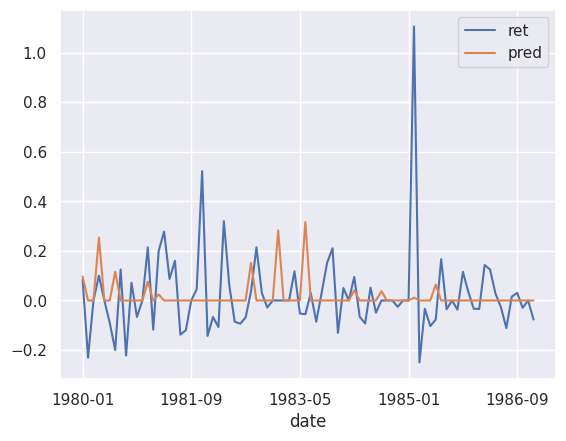

In [211]:
train_data_final[['date', target, 'pred']].set_index('date').plot();

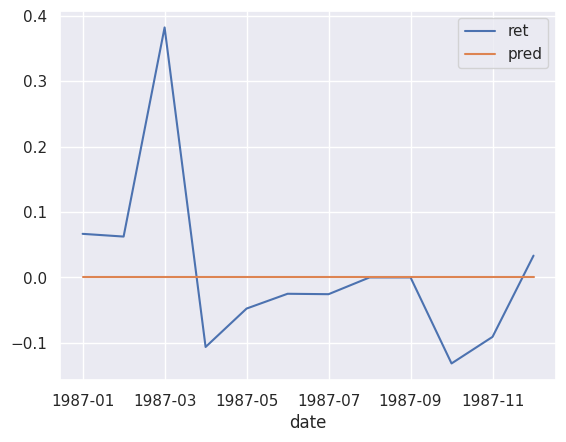

In [212]:
test_data_final[['date', target, 'pred']].set_index('date').plot();

In [213]:
mean_absolute_error(train_data_final[target], train_data_final['pred'])

0.10666129086147394

In [214]:
mean_absolute_error(test_data_final[target], test_data_final['pred'])

0.08099866666666666